In [1]:
import pandas as pd
from tasks.compute_index import format_df_for_computation, ST
from index.IndexComputation.GreenGrowthIndex import GreenGrowthIndex

In [2]:
import numpy as np

In [3]:
YEAR = 2020

# Import data
data = pd.read_csv('data/full_data/data.csv')
data = format_df_for_computation(data)
indicators = data.loc[YEAR].set_index('ISO') # Do Analysis on single year for now

# Compute index
GGI = GreenGrowthIndex(indicators=indicators, sustainability_targets=ST) # Index computation
test = GGI.to_long() # Results ! 

In [4]:
test.Aggregation.unique()

array(['Index', 'Indicator', 'Indicator_normed', 'Category', 'Dimension'],
      dtype=object)

# Tasks

Perform a Monte Carlo Analysis to study the effect of **missing values**. 

Step:
    - write a function that randomly removes value in the indicators dataframe. The function needs a parameter to control the percentage of missing values
    - Compute the index on a great number of modified dataframe (100 to 1000)
    - Combine the results to get uncertainty intervals
    

In [5]:
import random
import time
import numpy as np

# Try to extract functions, espacially if the function is central to the analysis
def add_random_nans(df, frac):
    df = df.copy()
    ix = [(row, col) for row in range(df.shape[0]) for col in range(df.shape[1])]
    for row, col in random.sample(ix, int(round(frac*len(ix)))):
        df.iat[row, col] = np.nan
    return df

In [6]:
def run_monte_carlo_nans(indicators,
                         sustainability_targets,
                         n_simulation=10,
                         nan_fracs=[0.01, 0.05, 0.1]
                        ):
    '''
    Function that runs the monte carlo simulation
    '''
    
    results = []
    
    for frac in nan_fracs: # First you loop over the parameters
        print(f'Running simulation for {frac * 100} % of missing values', end=': ')
        t = time.time()
        sim_res = []
        for i in range(n_simulation): # Then for each parameter you run a simulation
            

            indicators_nan = add_random_nans(indicators, frac)
            ggi_index = (
                GreenGrowthIndex(indicators=indicators_nan, sustainability_targets=ST)
                .to_long().query("Aggregation not in ['Indicator', 'Indicator_normed']") 
                .assign(nan_frac=frac, sim=i+1)
            )
            sim_res.append(ggi_index)
        
        print(round(time.time() - t, 2), 's')
            
        results.append(pd.concat(sim_res, axis=0))

    return pd.concat(results, axis=0)

In [7]:
results = run_monte_carlo_nans(indicators, ST, n_simulation=50) 

Running simulation for 1.0 % of missing values: 5.15 s
Running simulation for 5.0 % of missing values: 7.02 s
Running simulation for 10.0 % of missing values: 9.57 s


In [8]:
results.head()

,Variable,Value,Aggregation,nan_frac,sim
ISO,,,,,
AGO,Index,52.777096,Index,0.01,1
ALB,Index,70.739205,Index,0.01,1
ARG,Index,58.802134,Index,0.01,1
ARM,Index,61.924377,Index,0.01,1
AUS,Index,66.280846,Index,0.01,1


<AxesSubplot:>

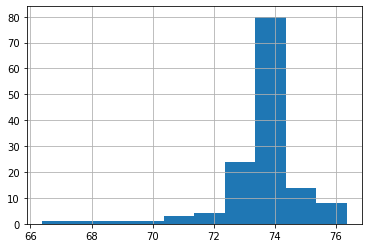

In [9]:
results.loc['FRA'].query('Variable == "Index"').Value.hist() # Example if possible result, here you can see that the result of the index can vary from 68 to 76

<AxesSubplot:>

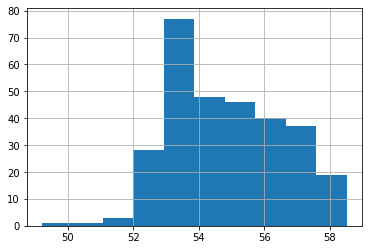

In [29]:
results.loc['RWA'].query('Variable == "Index"').Value.hist() 

In [33]:
def run_monte_carlo_noise(indicators,
                         sustainability_targets,
                         n_simulation=10,
                         noises=[0.01, 0.05, 0.1]
                        ):
    
    
    '''
    With inspiration from the previous function, try to write a function that adds noise to the data.
    The noise can be sampled from a gaussian distribution
    To be more precise, instead of add nans, this time the goal is to perform the following:
    "indicators_noisy = indicators + noise" 
    '''
    results = []
    for noise_level in noises: # First you loop over the parameters
        print(f'Running simulation for noise level {noise_level}', end=': ')
        t = time.time()
        sim_res = []

        for i in range(n_simulation): # Then for each parameter you run a simulation
            
            indicators_noisy = np.random.normal(indicators, noise_level, indicators.shape) # Noised indicator
            indicators_noisy = pd.DataFrame(indicators_noisy, index=indicators.index, columns=indicators.columns) # put in df for computing index
            
            ggi_index = (
                GreenGrowthIndex(indicators=indicators_noisy, sustainability_targets=ST)
                .to_long().query("Aggregation not in ['Indicator', 'Indicator_normed']") 
                .assign(noise=noise_level, sim=i+1)
            )
            sim_res.append(ggi_index)
        
        print(round(time.time() - t, 2), 's')
            
        results.append(pd.concat(sim_res, axis=0))

    return pd.concat(results, axis=0)
    
results = run_monte_carlo_noise(indicators, ST, n_simulation=100)

Running simulation for noise level 0.01: 8.69 s
Running simulation for noise level 0.05: 8.84 s
Running simulation for noise level 0.1: 9.46 s


<AxesSubplot:>

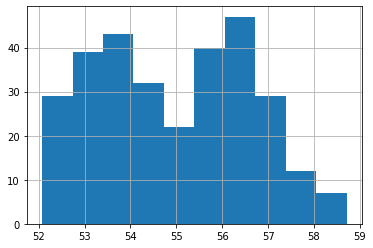

In [36]:
results.loc['RWA'].query('Variable == "Index"').Value.hist() # Example if possible result, here you can see that the result of the index can vary from 68 to 76